In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR"

/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import manifold

class CV_plot_utils:
  # Plot image
  def plot_img(img, range=[0, 255]):
      plt.imshow(img, vmin=range[0], vmax=range[1])
      plt.xlabel("xpixels")
      plt.ylabel("ypixels")
      plt.tight_layout()
      plt.show()
      plt.close()

  # Plots images in 2 rows: top row is query, bottom row is answer
  def plot_query_retrieval(img_query, imgs_retrieval, outFile):
      n_retrieval = len(imgs_retrieval)
      fig = plt.figure(figsize=(2*n_retrieval, 4))
      fig.suptitle("Image Retrieval (k={})".format(n_retrieval), fontsize=25)

      # Plot query image
      ax = plt.subplot(2, n_retrieval, 0 + 1)
      plt.imshow(img_query)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      for axis in ['top', 'bottom', 'left', 'right']:
          ax.spines[axis].set_linewidth(4)  # increase border thickness
          ax.spines[axis].set_color('black')  # set to black
      ax.set_title("query",  fontsize=14)  # set subplot title

      # Plot retrieval images
      for i, img in enumerate(imgs_retrieval):
          ax = plt.subplot(2, n_retrieval, n_retrieval + i + 1)
          plt.imshow(img)
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          for axis in ['top', 'bottom', 'left', 'right']:
              ax.spines[axis].set_linewidth(1)  # set border thickness
              ax.spines[axis].set_color('black')  # set to black
          ax.set_title("Rank #%d" % (i+1), fontsize=14)  # set subplot title

      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

  # Plot t-SNE of images
  def plot_tsne(X, imgs, outFile):

      def imscatter(x, y, images, ax=None, zoom=1.0):
          if ax is None:
              ax = plt.gca()
          x, y = np.atleast_1d(x, y)
          artists = []
          for x0, y0, img0 in zip(x, y, images):
              im = OffsetImage(img0, zoom=zoom)
              ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=True)
              artists.append(ax.add_artist(ab))
          ax.update_datalim(np.column_stack([x, y]))
          ax.autoscale()
          return artists

      def plot_embedding(X, imgs, title=None):
          x_min, x_max = np.min(X, 0), np.max(X, 0)
          X = (X - x_min) / (x_max - x_min)

          plt.figure()
          ax = plt.subplot(111)
          for i in range(X.shape[0]):
              plt.text(X[i, 0], X[i, 1], ".", fontdict={'weight': 'bold', 'size': 9})
          if hasattr(offsetbox, 'AnnotationBbox'):
              imscatter(X[:,0], X[:,1], imgs, zoom=0.3, ax=ax)

          plt.xticks([]), plt.yticks([])
          if title is not None:
              plt.title(title, fontsize=18)

      tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
      X_tsne = tsne.fit_transform(X)
      plot_embedding(X_tsne, imgs, "t-SNE embeddings")
      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

  # Plot image reconstructions
  def plot_reconstructions(imgs, imgs_reconstruct, outFile,
                          range_imgs=[0, 255],
                          range_imgs_reconstruct=[0, 1]):
      # Create plot to save
      assert len(imgs) == len(imgs_reconstruct)
      fig = plt.figure(figsize=(20, 4))
      fig.suptitle("Image Reconstructions", fontsize=35)
      n = min(len(imgs), 10)
      for i in range(n):

          # Plot original image
          ax = plt.subplot(2, n, i + 1)
          plt.imshow(imgs[i],
                    vmin=range_imgs[0],
                    vmax=range_imgs[1])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

          # Plot reconstructed image
          ax = plt.subplot(2, n, n + i + 1)
          plt.imshow(imgs_reconstruct[i],
                    vmin=range_imgs_reconstruct[0],
                    vmax=range_imgs_reconstruct[1])
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

      if outFile is None:
          plt.show()
      else:
          plt.savefig(outFile, bbox_inches='tight')
      plt.close()

In [6]:
import os
import skimage.io
from multiprocessing import Pool

class CV_IO_utils:
  # Read image
  def read_img(filePath):
      return skimage.io.imread(filePath, as_gray=False)

  # Read images with common extensions from a directory
  def read_imgs_dir(dirPath, extensions, parallel=True):
      args = [os.path.join(dirPath, filename)
              for filename in os.listdir(dirPath)
              if any(filename.lower().endswith(ext) for ext in extensions)]
      if parallel:
          pool = Pool()
          imgs = pool.map(CV_IO_utils.read_img, args)
          pool.close()
          pool.join()
      else:
          imgs = [read_img(arg) for arg in args]
      return imgs

  # Save image to file
  def save_img(filePath, img):
      skimage.io.imsave(filePath, img)

In [7]:
from multiprocessing import Pool
from skimage.transform import resize

# Apply transformations to multiple images
class CV_transform_utils:
    
  def apply_transformer(imgs, transformer, parallel=True):
      if parallel:
          pool = Pool()
          imgs_transform = pool.map(transformer, [img for img in imgs])
          pool.close()
          pool.join()
      else:
          imgs_transform = [transformer(img) for img in imgs]
      return imgs_transform

  # Normalize image data [0, 255] -> [0.0, 1.0]
  def normalize_img(img):
      return img / 255.

  # Resize image
  def resize_img(img, shape_resized):
      img_resized = resize(img, shape_resized,
                          anti_aliasing=True,
                          preserve_range=True)
      assert img_resized.shape == shape_resized
      return img_resized

  # Flatten image
  def flatten_img(img):
      return img.flatten("C")

In [8]:
import random
import numpy as np

class utils:
    # Get split indices
  def split(fracs, N, seed):
      fracs = [round(frac, 2) for frac in fracs]
      if sum(fracs) != 1.00:
          raise Exception("fracs do not sum to one!")

      # Shuffle ordered indices
      indices = list(range(N))
      random.Random(seed).shuffle(indices)
      indices = np.array(indices, dtype=int)

      # Get numbers per group
      n_fracs = []
      for i in range(len(fracs) - 1):
          n_fracs.append(int(max(fracs[i] * N, 0)))
      n_fracs.append(int(max(N - sum(n_fracs), 0)))

      if sum(n_fracs) != N:
          raise Exception("n_fracs do not sum to N!")

      # Sample indices
      n_selected = 0
      indices_fracs = []
      for n_frac in n_fracs:
          indices_frac = indices[n_selected:n_selected + n_frac]
          indices_fracs.append(indices_frac)
          n_selected += n_frac

      # Check no intersections
      for a, indices_frac_A in enumerate(indices_fracs):
          for b, indices_frac_B in enumerate(indices_fracs):
              if a == b:
                  continue
              if utils.is_intersect(indices_frac_A, indices_frac_B):
                  raise Exception("there are intersections!")

      return indices_fracs

  # Is there intersection?
  def is_intersect(arr1, arr2):
      n_intersect = len(np.intersect1d(arr1, arr2))
      if n_intersect == 0: return False
      else: return True

In [9]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
import copy
import sklearn.metrics as metric
from statistics import mean
import re

correct = 0
wrong = 0
loss_ = []
acc_ = []
ground_truth = []
retrieval_labels = []
prec_list = []
rec_list = []

acc_transfer = []
loss_transfer = []
prec_transfer = []
rec_transfer = []

retrieval_label=os.listdir(r"/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/train")
truth_label=os.listdir(r"/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/testt")

# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = CV_transform_utils.resize_img(img, self.shape_resize)
        img_transformed = CV_transform_utils.normalize_img(img_transformed)
        return img_transformed

transfer = ['Xception', 'VGG16', 'VGG19', 'ResNet50', 'ResNet101', 
            'ResNet152', 'ResNet50V2', 'ResNet101V2', 'ResNet152V2',
            'InceptionV3', 'InceptionResNetV2', 'MobileNet', 'MobileNetV2',
            'DenseNet121', 'DenseNet169', 'DenseNet201', 'NASNetMobile',
            'NASNetLarge', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2',
            'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6',
            'EfficientNetB7']

# Run mode: (autoencoder -> simpleAE, convAE) or (transfer learning -> vgg19)
modelName = "vgg19"  # try: "simpleAE", "convAE", "vgg19"
trainModel = True
parallel = True  # use multicore processing

# Make paths
dataTrainDir = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/train"
dataTestDir = "/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/testt"
outDir = os.path.join(os.getcwd(), "output", modelName)
if not os.path.exists(outDir):
    os.makedirs(outDir)

# Read images
extensions = [".jpg"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = CV_IO_utils.read_imgs_dir(dataTrainDir, extensions, parallel=parallel)
print("Reading test images from '{}'...".format(dataTestDir))
imgs_test = CV_IO_utils.read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
print("Image shape = {}".format(shape_img))
print("Loading VGG19 pre-trained model...")
model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False,
                                            input_shape=shape_img)
model.summary()

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
n_epochs = None
    # Build models

# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))

transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = CV_transform_utils.apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = CV_transform_utils.apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))

# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))

# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=10, metric="cosine")
knn.fit(E_train_flatten)

# Perform image retrieval on test images
print("Performing image retrieval on test images...")
for i, emb_flatten in enumerate(E_test_flatten):
    _, indices = knn.kneighbors([emb_flatten]) # find k nearest train neighbours
    img_query = imgs_test[i] # query image
    imgs_retrieval = [imgs_train[idx] for idx in indices.flatten()] # retrieval images
    for x in indices.flatten():
      if truth_label[i][:3] in retrieval_label[x]:
        correct = correct + 1
      else:
        wrong = wrong + 1
    loss_.append((wrong/5))
    acc_.append((correct/5))
    correct = 0
    wrong = 0

    # Precision Recall
    for x in indices.flatten():
      ground_truth.append(re.split("(\d.*)", truth_label[i])[0])
      retrieval_labels.append(re.split("(\d.*)", retrieval_label[x])[0])
    
    rec_list.append(metric.recall_score(ground_truth, retrieval_labels, average='weighted'))
    prec_list.append(metric.precision_score(ground_truth, retrieval_labels, average='weighted'))

    ground_truth.clear()
    retrieval_labels.clear()

    outFile = os.path.join(outDir, "{}_retrieval_{}.jpg".format(modelName, i))
    CV_plot_utils.plot_query_retrieval(img_query, imgs_retrieval, outFile)

print("retrieval accuracy: {}".format(mean(acc_)))
print("retrieval loss: {}".format(mean(loss_)))
print("retrieval precision: {}".format(mean(prec_list)))
print("retrieval recall: {}".format(mean(rec_list)))

Reading train images from '/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/train'...
Reading test images from '/content/drive/MyDrive/Colab Notebooks/Kuliah/Semester 7/TKC/CBIR/Dataset/testt'...
Image shape = (207, 244, 3)
Loading VGG19 pre-trained model...
219070464/219055592 [==============================] - 5s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 207, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 103, 121, 32  864         ['input_1[0][0]']                
                          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and 

retrieval accuracy: 1.32
retrieval loss: 0.68
retrieval precision: 1.0
retrieval recall: 0.66


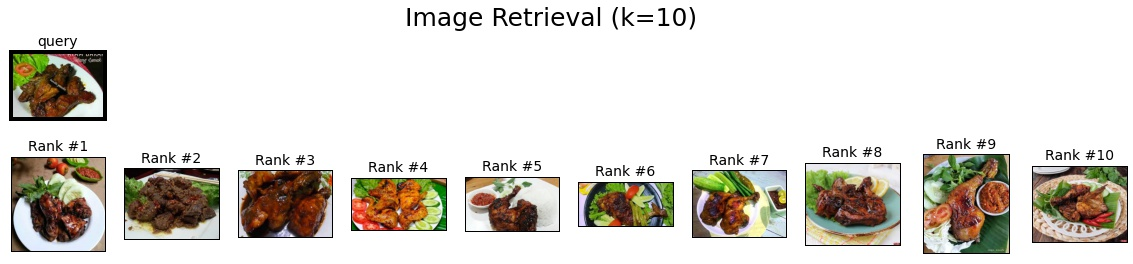